## GMM Estimation of Model Parameters of Expectation Formation

- This notebook includes functions that estimate the parameter of rigidity for different models
- It allows for flexible choices of moments to be used, forecast error, disagreement, and uncertainty, etc. 
- It includes 
  - A general function that implements the estimation using the minimum distance algorithm. 
  - Model-specific functions that take real-time data and process parameters as inputs and produces forecasts and moments as outputs. It is model-specific because different models of expectation formation bring about different forecasts. 
  - Auxiliary functions that compute the moments as well as the difference of data and model prediction, which will be used as inputs for GMM estimator. 

### 1. Estimation algorithms 

In [1]:
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
#from statsmodels.tsa.arima_process import arma_generate_sample
import pandas as pd

In [2]:
# a general-purpose estimating function of the parameter
def Estimator(obj_func,para_guess,method='CG'):
    """
    Inputs
    ------
    - moments: a function of the rigidity model parameter  
    - method: method of optimization 
    
    Outputs
    -------
    - parameter: an array of estimated parameter
    """
    
    parameter = minimize(obj_func,x0 = para_guess,method=method)['x']
    return parameter 

In [3]:
# a function that prepares moment conditions. So far the loss being simply the norm of the difference
def PrepMom(model_moments,data_moments):
    """
    Inputs
    -----
    model_moments: an array of moments from a certain model, i.e. forecast error, disagreement and uncertainty. 
    data_moments: an array of moments computed from the survey data
    
    Outputs
    ------
    diff: the Euclidean distance of two arrays of data and model 
    
    """
    diff = np.linalg.norm(model_moments - data_moments)
    return diff

In [4]:
## auxiliary functions 
def hstepvar(h,sigma,rho):
    return sum([ rho**(2*i)*sigma**2 for i in range(h)] )

np.random.seed(12345)
def hstepfe(h,sigma,rho):
    return sum([rho**i*(np.random.randn(1)*sigma)*np.random.randn(h)[i] for i in range(h)])
## This is not correct. 


def ForecastPlot(test):
    plt.figure(figsize=([3,13]))
    for i,val in enumerate(test):
        plt.subplot(4,1,i+1)
        plt.plot(test[val],label=val)
        plt.legend(loc=1)
        
        
def ForecastPlotDiag(test,data):
    plt.figure(figsize=([3,13]))
    for i,val in enumerate(test):
        plt.subplot(4,1,i+1)
        plt.plot(test[val],label='model:'+ val)
        plt.plot(np.array(data[val]),label='data:'+ val)
        plt.legend(loc=1)
        
        
### AR1 simulator 
def AR1_simulator(rho,sigma,nobs):
    xxx = np.zeros(nobs+1)
    shocks = np.random.randn(nobs+1)*sigma
    xxx[0] = 0 
    for i in range(nobs):
        xxx[i+1] = rho*xxx[i] + shocks[i+1]
    return xxx[1:]

In [5]:
## some process parameters 
rho = 0.95
sigma = 0.1
process_para = {'rho':rho,
                'sigma':sigma}

In [6]:
### create fake real-time data 
xxx = AR1_simulator(rho,sigma,100)

In [8]:
## RE class 
class RationalExpectation:
    def __init__(self,real_time,horizon=1,process_para = process_para,exp_para = {},max_back =10):
        self.real_time = real_time
        self.horizon = horizon
        self.process_para = process_para
        self.max_back = max_back
    
    def GetRealization(self,realized_series):
        self.realized = realized_series
        
    def SimulateRealization(self):
        n = len(self.real_time)
        rho = self.process_para['rho']
        sigma =self.process_para['sigma']
        shocks = np.random.randn(n)*sigma
        realized = np.zeros(n)
        for i in range(n):
            cum_shock = sum([rho**h*shocks[i+h] for h in range(self.horizon)])
            realized[i] = rho**self.horizon*self.real_time[i] + cum_shock
        self.realized = realized        
        
    def REForecaster(self):
        ## parameters
        n = len(self.real_time)
        rho = self.process_para['rho']
        sigma =self.process_para['sigma']
        
        ## parameters
        max_back = self.max_back
        real_time = self.real_time
        horizon = self.horizon
        
        ## forecast moments 
        Disg =np.zeros(n)
        infoset = real_time
        nowcast = infoset
        forecast = rho**horizon*nowcast
        Var = hstepvar(horizon,sigma,rho)* np.ones(n)
        FE = forecast - self.realized ## forecast errors depend on realized shocks 
        return {"Forecast":forecast,
                "FE":FE,
               "Disg":Disg,
               "Var":Var}

In [9]:
### create a RE instance 
FE_instance = RationalExpectation(real_time = xxx)

In [10]:
### simulate a realized series 
FE_instance.SimulateRealization()

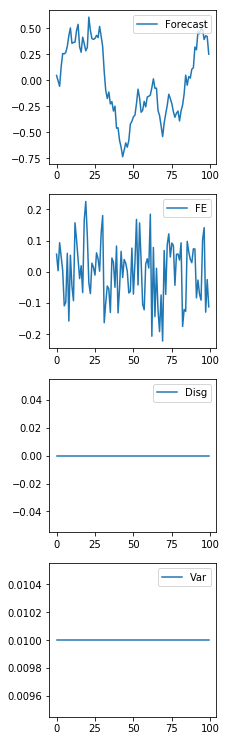

In [11]:
### forecster
fe_moms = FE_instance.REForecaster()
ForecastPlot(fe_moms)

In [21]:
## expectation parameters 
SE_para_default = {'lambda':1}

In [22]:
## SE class 
class StickyExpectation:
    def __init__(self,real_time,horizon=1,process_para = process_para,exp_para = SE_para_default,max_back =10):
        self.real_time = real_time
        self.horizon = horizon
        self.process_para = process_para
        self.exp_para = exp_para
        self.max_back = max_back
        self.data_moms_dct ={}
        self.para_est = {}
    def GetRealization(self,realized_series):
        self.realized = realized_series   
    
    def SimulateRealization(self):
        n = len(self.real_time)
        rho = self.process_para['rho']
        sigma =self.process_para['sigma']
        shocks = np.random.randn(n)*sigma
        realized = np.zeros(n)
        for i in range(n):
            cum_shock = sum([rho**h*shocks[i+h] for h in range(self.horizon)])
            realized[i] = rho**self.horizon*self.real_time[i] +cum_shock
        self.realized = realized
        
    def SEForecaster(self):
        ## parameters
        n = len(self.real_time)
        rho = self.process_para['rho']
        sigma =self.process_para['sigma']
        lbd = self.exp_para['lambda']
        
        ## parameters
        max_back = self.max_back
        real_time = self.real_time
        horizon = self.horizon
        
        
        ## forecast moments 
        #FE = sum( [lbd*(1-lbd)**tau*hstepfe(horizon+tau,sigma,rho) for tau in range(max_back)] ) * np.ones(n) # a function of lambda, real-time and process_para 
        Var = sum([ lbd*(1-lbd)**tau*hstepvar(horizon+tau,sigma,rho) for tau in range(max_back)] ) * np.ones(n)  
        # same as above 
        nowcast = sum([ lbd*(1-lbd)**tau*(rho**tau)*np.roll(real_time,tau) for tau in range(max_back)]) 
        # the first tau needs to be burned
        forecast = rho**horizon*nowcast
        FE = forecast - self.realized
        Disg =  sum([ lbd*(1-lbd)**tau*(rho**(tau+horizon)*np.roll(real_time,tau)-forecast)**2 for tau in range(max_back)] )
        return {"Forecast":forecast, 
                "FE":FE,
                "Disg":Disg,
                "Var":Var}
    
    ## a function estimating SE model parameter only 
    def SE_EstObjfunc(self,lbd,moments = ['Forecast','Disg','Var']):
        """
        input
        -----
        lbd: the parameter of SE model to be estimated
        
        output
        -----
        the objective function to minmize
        """
        SE_para = {"lambda":lbd}
        self.exp_para = SE_para  # give the new lambda
        data_moms_dct = self.data_moms_dct
        
        SE_moms_dct = self.SEForecaster()
        SE_moms = np.array([SE_moms_dct[key] for key in moments] )
        data_moms = np.array([data_moms_dct[key] for key in moments] )
        obj_func = PrepMom(SE_moms,data_moms)
        return obj_func 
    
    ## feeds the instance with data moments dictionary 
    def GetDataMoments(self,data_moms_dct):
        self.data_moms_dct = data_moms_dct
        
    ## invoke the estimator 
    def ParaEstimate(self,para_guess=0.2,method='CG'):
        self.para_est = Estimator(self.SE_EstObjfunc,para_guess=para_guess,method='CG')

In [23]:
### create a SE instance using fake real time data 
SE_instance = StickyExpectation(real_time = xxx)

In [24]:
### simulate a realized series 
SE_instance.SimulateRealization()

In [25]:
### fake data moments 
data_moms_dct2 = SE_instance.SEForecaster()

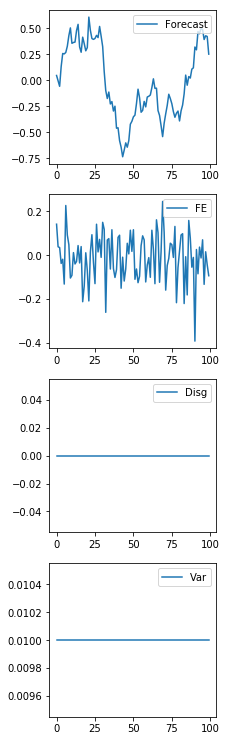

In [26]:
ForecastPlot(data_moms_dct2)

In [27]:
### feed the data moments
SE_instance.GetDataMoments(data_moms_dct2)

In [28]:
### invokes the estimation 
SE_instance.ParaEstimate(para_guess=0.9)
SE_instance.para_est

array([0.9])

In [29]:
## class of Noisy information 

def NoisyInformation(self,real_time,horizon=1,process_para = process_para, exp_para = NI_para_default):
    def __init__(self):
        self.real_time = real_time
        self.horizon = horizon
        self.process_para = process_para
        self.exp_para = exp_para
    # a function that generates population moments according to NI 
    
    def NIForecaster(real_time,horizon =10,process_para = process_para,exp_para = exp_para):
        rho = process_para['rho']
        sigma = process_para['sigma']
        sigma_pr = exp_para['sigma_pr']
        sigma_pb = exp_para['sigma_pb']
        NIFE = # a function of lambda, real-time and process_para 
        NIDisg = 0 # same as above
        NIVar = # same as above 
        return {"FE":NIFE,
                "Disg":NIDisg,
                "Var":NIVar}


SyntaxError: invalid syntax (<ipython-input-29-4ecd29fa328b>, line 16)